## STFT (Short-time Fourier transform)

Sources:

- https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html
- https://klyshko.github.io/teaching/2019-02-22-teaching
- https://github.com/brihijoshi/vanilla-stft-mfcc
- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2.html

Summary:
1. The Fourier transform can be used to decompose a signal into its consituent sinusoidal frequencies and their phase content
2. The Fourier transform yields frequency information that is averaged over the entire time domain. However, the information on when these frequencies occur is hidden in the transform.
3. STFT applies the Fourier transform on short segments of the signal so that the frequency information is averaged over a much shorter period of time, over time

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/Ensta/MI205/code_audio_processing/code_MI205'


Mounted at /content/gdrive/


In [2]:
import librosa
import librosa.display as ld

from IPython.display import Audio 
from matplotlib import pyplot as plt        
import numpy as np
import scipy as sp

In [3]:
# Upload bass-like intro

bass, sr_b = librosa.load(DATA_DIR+'/STFT/bass.wav')

bass.shape, sr_b, len(bass)/sr_b

((105840,), 22050, 4.8)

In [4]:
# Upload piano progression

piano, sr_p = librosa.load(DATA_DIR+'/STFT/piano.wav')
piano = piano[:len(bass)] # let's make the piano a bit shorter

piano.shape, sr_p, len(piano)/sr_p

((105840,), 22050, 4.8)

In [5]:
sr_b == sr_p

True

In [6]:
sr = sr_b

In [7]:
# Let's concat the audio in one unique recording
# Multiply the piano recording samples by 5 to increase their amplitude (i.e. loudness) relative to the bass signal

concat_audio = np.concatenate((bass, 5*piano))

In [8]:
Audio(concat_audio, rate=sr)

In [10]:
# Fast Fourier Transform

fft_spectrum = np.fft.rfft(concat_audio)

In [ ]:
type(fft_spectrum), fft_spectrum.shape, type(fft_spectrum[0]), fft_spectrum[42]

(numpy.ndarray,
 (105841,),
 numpy.complex128,
 (-4.681639164428505-22.42283732978961j))

In [11]:
freq = np.fft.rfftfreq(concat_audio.size, d=1./sr)

In [12]:
type(freq), freq.shape, type(freq[0]), freq[42]

(numpy.ndarray, (105841,), numpy.float64, 4.375)

In [13]:
freq[:10]

array([0.        , 0.10416667, 0.20833333, 0.3125    , 0.41666667,
       0.52083333, 0.625     , 0.72916667, 0.83333333, 0.9375    ])

In [14]:
fft_spectrum_abs = np.abs(fft_spectrum)

In [15]:
type(fft_spectrum), fft_spectrum.shape, type(fft_spectrum[0]), fft_spectrum[42]

(numpy.ndarray,
 (105841,),
 numpy.complex128,
 (-4.681639164428505-22.42283732978961j))

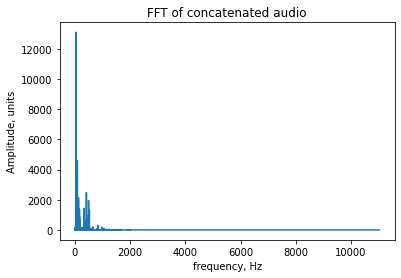

In [16]:
plt.plot(freq, fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.title("FFT of concatenated audio")
plt.show()

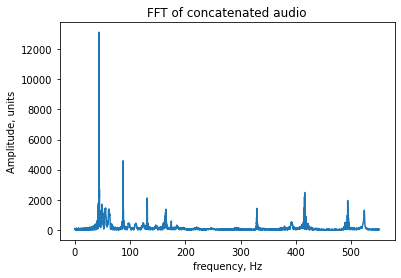

In [18]:
# Zoom in in the lower frequencies

plt.plot(freq[:len(concat_audio)//40], fft_spectrum_abs[:len(concat_audio)//40])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.title("FFT of concatenated audio")
plt.show()

The graph above shows all the frequencies in the recording, but it is not possible to understand which frequencies belong to the bass and which ones to the piano.

Because we have also the individual recording, we can make the same graph for the individual instruments.

In [19]:
def fft_and_plot(sig, title, sr=sr, zoom_factor=2):
    fft_spectrum = np.fft.rfft(sig)
    freq = np.fft.rfftfreq(sig.size, d=1./sr)
    fft_spectrum_abs = np.abs(fft_spectrum)
    plt.plot(freq[:len(concat_audio)//zoom_factor], fft_spectrum_abs[:len(concat_audio)//zoom_factor])
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.title(title)
    plt.show()

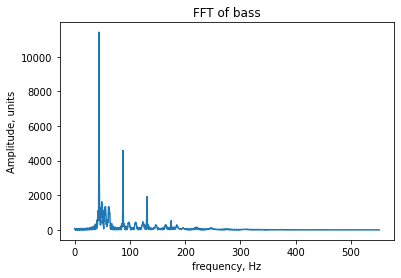

In [20]:
fft_and_plot(bass, 'FFT of bass', zoom_factor=80)

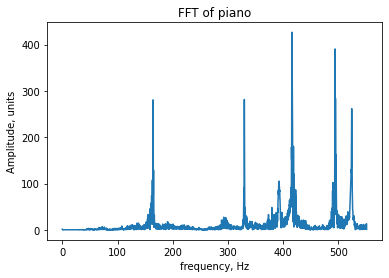

In [ ]:
fft_and_plot(piano, 'FFT of piano', zoom_factor=80)

Another solution to distinguish between the two instruments is to use the STFT.

Instead of considering the whole signal together, STFT takes a series of snapshots of the frequencies every fixed interval of samples.

In [21]:
# source: https://github.com/brihijoshi/vanilla-stft-mfcc/blob/master/notebook.ipynb

def stft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff %2==0:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
                    
        dft_window = np.fft.rfft(mult_window)
        
        stft_res.append(dft_window)
        
        counter+=1
    
    return np.array(stft_res)

In [27]:
res = stft(concat_audio, window_size = 500, hopsize = int(500/4))

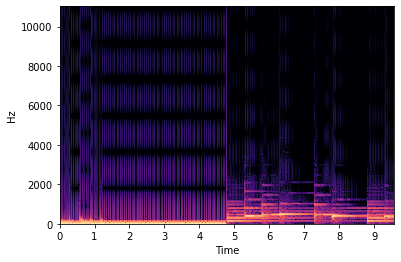

In [28]:
ld.specshow(librosa.amplitude_to_db(np.abs(res.T),ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')

In [29]:
# Librosa STFT implementation for comparison

res_librosa = np.abs(librosa.stft(concat_audio, hop_length=int(500/4), window='hamming', n_fft=512, win_length=500, center=False))

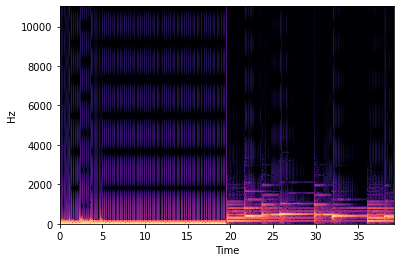

In [30]:
ld.specshow(librosa.amplitude_to_db(res_librosa, ref=np.max), y_axis='linear', x_axis='time')

### <span style="color:red">Homework</span>

Play around with the parameters of the STFT, such as the type of window and the padding.

If you want to go deeper on both theory and code, click [here](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2.html)

# Voice Activity Detection (VAD)

Traditional VAD sources:
- http://practicalcryptography.com/miscellaneous/machine-learning/voice-activity-detection-vad-tutorial/
- https://speechprocessingbook.aalto.fi/Recognition/Voice_activity_detection.html
- https://superkogito.github.io/blog/2020/02/09/naive_vad.html

Neural Network VAD examples:
- https://github.com/nicklashansen/voice-activity-detection

Summary:
1. Traditional methods for VAD aim to determine speech-related regions of a recording using different features from the signal. The simplest feature is the frame energy, but other are possible (ex. zero crossing rate, autocorrelation coefficient, etc...)
2. While energy-based VAD work well with low level of noise, as the SNR (signal-to-noise ratio) decreases, it becomes harded to distinguish voice from background noise.

In [31]:
import librosa
from IPython.display import Audio 

In [32]:
# Upload clean recording

rec_clean, sr_rec_c = librosa.load(DATA_DIR+'/vad/clean.wav')

rec_clean.shape, sr_rec_c, len(rec_clean)/sr_rec_c

((1284587,), 22050, 58.25791383219955)

In [33]:
Audio(rec_clean, rate=sr_rec_c)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
# Upload noise

noise, sr_n = librosa.load(DATA_DIR+'/spectral_subtraction_data/ex1/noise.wav')

noise.shape, sr_n, len(noise)/sr_n

((259419,), 22050, 11.765034013605442)

In [35]:
Audio(noise, rate=sr_n)

In [36]:
min_samples = min(len(rec_clean), len(noise))
min_samples

259419

In [37]:
rec_clean = rec_clean[:min_samples]
noise = noise[:min_samples]

In [38]:
# Mix clean and noise to make noisy recording
# TODO: see how the result change by changing the ration between audio and noise (a.k.a. signal-to-noise ratio)

rec_noisy = rec_clean + noise
sr_rec_n = sr_rec_c

In [39]:
Audio(rec_noisy, rate=sr_rec_n)

In [40]:
# source: https://superkogito.github.io/blog/2020/02/09/naive_vad.html

import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt


def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
    """
    transform a signal into a series of overlapping frames (=Frame blocking).

    Args:
        sig     (array) : a mono audio signal (Nx1) from which to compute features.
        fs        (int) : the sampling frequency of the signal we are working with.
                          Default is 16000.
        win_len (float) : window length in sec.
                          Default is 0.025.
        win_hop (float) : step between successive windows in sec.
                          Default is 0.01.

    Returns:
        array of frames.
        frame length.

    Notes:
    ------
        Uses the stride trick to accelerate the processing.
    """
    # run checks and assertions
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()

### Clean recording

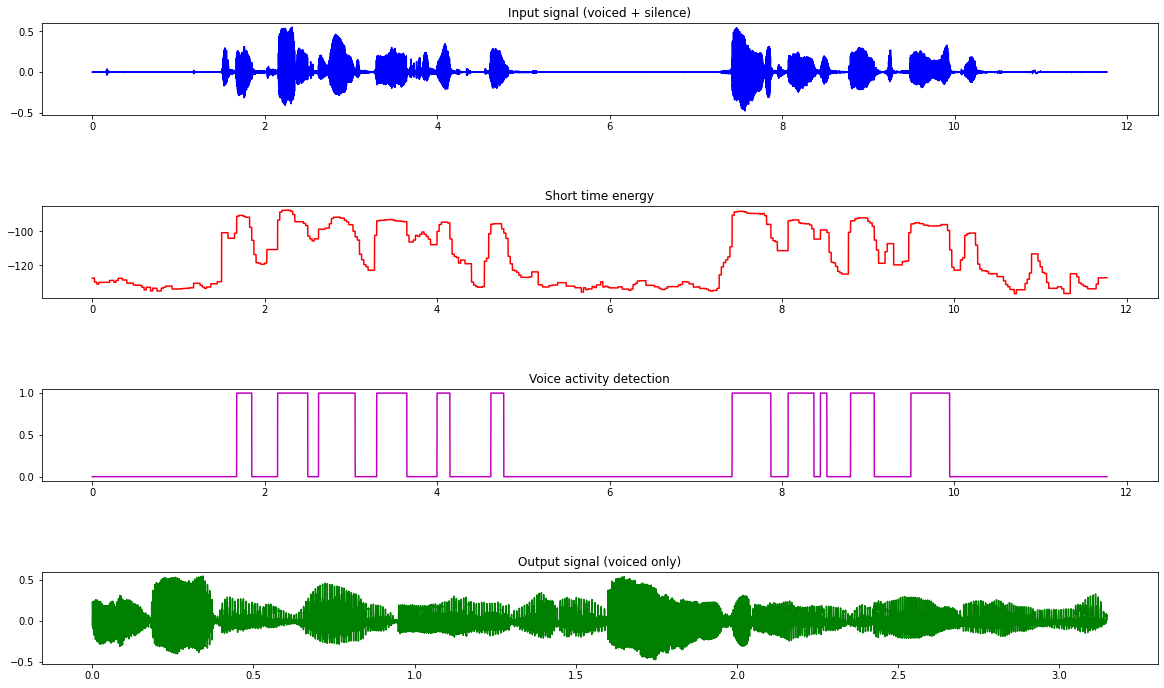

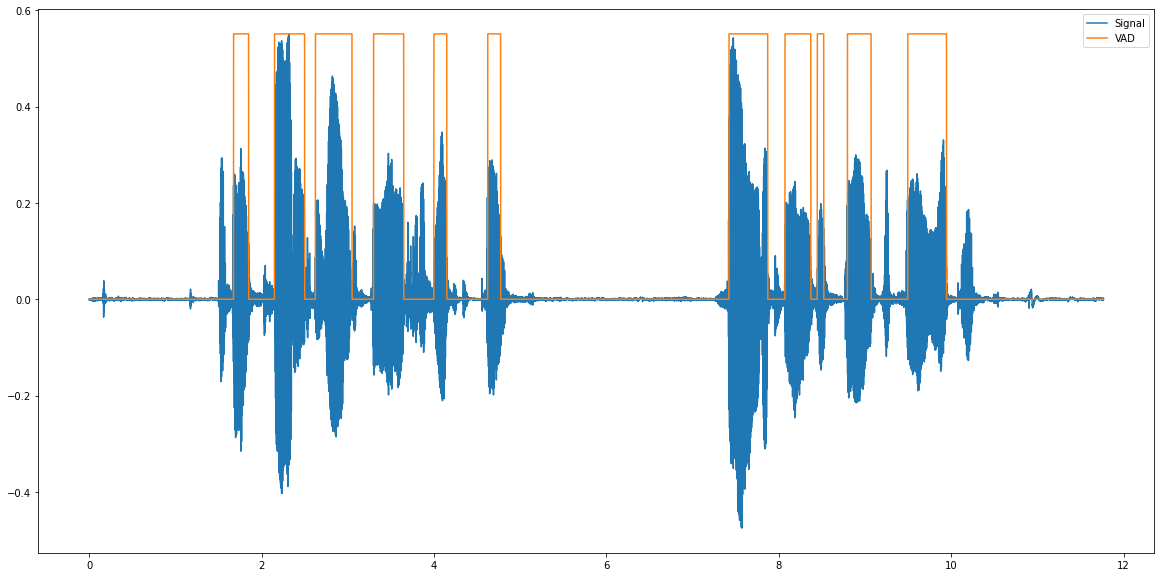

In [41]:
# get voiced frames
energy, vad, voiced = naive_frame_energy_vad(rec_clean, 
                                             sr_rec_c, 
                                             threshold=-100,
                                             win_len=0.025, 
                                             win_hop=0.025)

# plot results
multi_plots(data=[rec_clean, energy, vad, voiced],
            titles=["Input signal (voiced + silence)", 
                    "Short time energy",
                    "Voice activity detection", 
                    "Output signal (voiced only)"],
            fs=sr_rec_c, plot_rows=4, step=1)

### Noisy recording

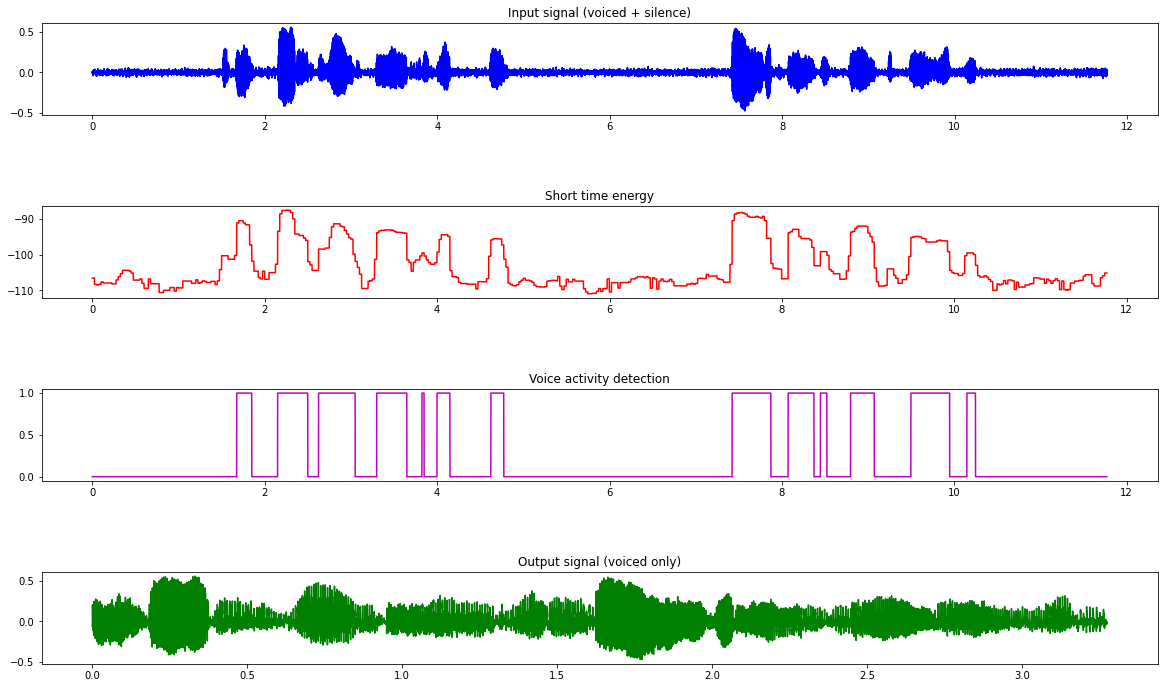

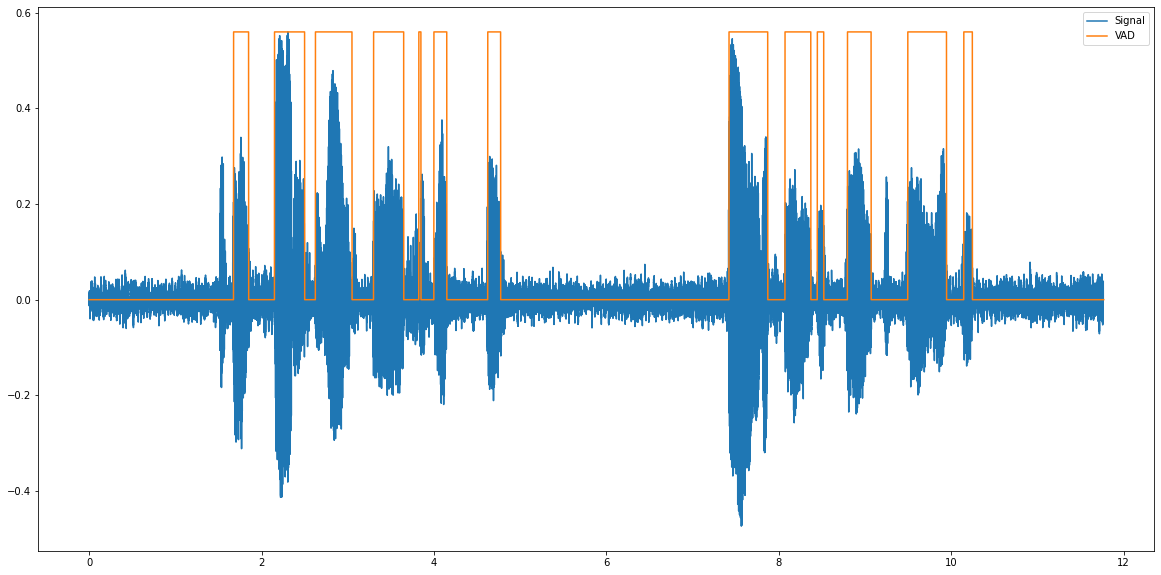

In [42]:
# get voiced frames
energy, vad, voiced = naive_frame_energy_vad(rec_noisy, 
                                             sr_rec_n, 
                                             threshold=-100,
                                             win_len=0.025, 
                                             win_hop=0.025)

# plot results
multi_plots(data=[rec_noisy, energy, vad, voiced],
            titles=["Input signal (voiced + silence)", 
                    "Short time energy",
                    "Voice activity detection", 
                    "Output signal (voiced only)"],
            fs=sr_rec_n, plot_rows=4, step=1)

### <span style="color:red">Homework</span>


1. Create a new audio with a lower SNR and reproduce the results. Does the VAD work better or worse? 
2. The VAD above has no trained parameters. 
    - If you could train one parameter of the model, what would it be?
    - Try a series of potential candidates for such parameter and see for which value it perform best* under different SNR conditions. Is there an optimal value for all noise levels?
    
\* As there is no labeled data, you can only check using the VAD graph and checking manually with the audio

# Spectral subtraction and Wiener filters

Sources:
- https://github.com/shun60s/spectral-subtraction
- http://dsp-book.narod.ru/304.pdf
- https://www.eurasip.org/Proceedings/Ext/ISCCSP2006/defevent/papers/cr1078.pdf

In [ ]:
import numpy as np
import scipy
import librosa

import IPython.display as ipd

In [ ]:
ex = "ex1" # possible values {ex1, ex2}

In [ ]:
infile=f'spectral_subtraction_data/{ex}/mix.wav'
noisefile=f'spectral_subtraction_data/{ex}/noise.wav'

outfile_easy=f'spectral_subtraction_data/{ex}/mix_clean_easy.wav'

In [ ]:
# Noisy mix

ipd.Audio(infile) 

In [ ]:
# Noise

ipd.Audio(noisefile) 

In [ ]:
# Step 1: Upload noisy recording

mix, sr = librosa.load(infile, sr=None, mono=True) 
s = librosa.stft(mix)     # Short-time Fourier transform
ss = np.abs(s)            # get magnitude
angle = np.angle(s)       # get phase
b = np.exp(1.0j* angle)   # use this phase information when Inverse Transfor

In [ ]:
sr

16000

In [ ]:
# 1.1 Explore STFT

type(s), s.shape, type(s[0]), type(s[0][0])

(numpy.ndarray, (1025, 368), numpy.ndarray, numpy.complex64)

In [ ]:
# 1.2 Explore the magnitude

type(ss), ss.shape, type(ss[0]), type(ss[0][0])

(numpy.ndarray, (1025, 368), numpy.ndarray, numpy.float32)

In [ ]:
# 1.3 Explore the angle

type(angle), angle.shape, type(angle[0]), type(angle[0][0])

(numpy.ndarray, (1025, 368), numpy.ndarray, numpy.float32)

In [ ]:
# 1.4 Explore the imaginary part (i.e. the phase)

type(b), b.shape, type(b[0]), type(b[0][0])

(numpy.ndarray, (1025, 368), numpy.ndarray, numpy.complex64)

In [ ]:
# Step 2: Upload recording only noise

noise, n_sr = librosa.load(noisefile, sr=None, mono=True)
ns = librosa.stft(noise)   # Short-time Fourier transform
nss = np.abs(ns)           # get magnitude
mns = np.mean(nss, axis=1) # get mean

In [ ]:
nss.shape

(1025, 368)

In [ ]:
# The average is along the time dimension
# The noise is represented as a temporal average for each frequency bin

mns.shape

(1025,)

In [ ]:
# Step 3: Subtract noise spectral mean from input spectral and istft (Inverse Short-Time Fourier Transform)

sa = ss - mns.reshape((mns.shape[0], 1)) # reshape for broadcast to subtract
sa0 = sa * b                             # apply phase information
y = librosa.istft(sa0)                   # back to time domain signal

In [ ]:
# Step 4: Save as a wav file

scipy.io.wavfile.write(outfile_easy, sr, y) 

In [ ]:
# Cleaned mix

ipd.Audio(outfile_easy) 

### <span style="color:red">Homework</span>

1. Example 1 works better than example 2 (i.e. better noise removal). Why?
    - What is the difference in the noise between example 1 and example 2?
    - What is the specific step/transform/operation/line of code in the example above that make the system too simplistic for example 2?
2. (HARD) What if the noise recording is not available, but only mix.wav?
    - Implement such system